## Overview

This notebook demonstrates the core functionality of the `isgri` package for ISGRI lightcurve analysis:

- Loading events and PIF files
- Creating lightcurves with different binning and energy ranges
- Analyzing detector modules individually
- Computing quality metrics (chi-squared variability tests)
- Custom analysis techniques

**Data:** ScW 255900280010 observing SGR 1935+2154

## 1. Installation & Setup
<div class="alert alert-block alert-info">
<b>If not installed:</b> pip install isgri
</div>




In [1]:
from isgri.utils import LightCurve
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading Data

In [2]:
# Load with PIF file (recommended)
lc = LightCurve.load_data(events_path="data/")  # Looks for file isgri_events in the folder
print(lc.metadata)
# Load with PIF file (recommended)
lc = LightCurve.load_data(events_path="data/", pif_path="data/255900280010_isgri_model.fits.gz")
print(lc.metadata)

{'REVOL': 2559, 'SWID': '255900280010', 'TSTART': 8320.63230042977, 'TSTOP': 8320.6736661982, 'TELAPSE': 3573.9999511221, 'OBT_TSTART': '00009111764710981632', 'OBT_TSTOP': '00009111768458592256', 'RA_SCX': 286.822875976562, 'DEC_SCX': 20.2762775421143, 'RA_SCZ': 199.37516784668, 'DEC_SCZ': -6.87311124801636, 'SRC_RA': None, 'SRC_DEC': None, 'Source_Name': None, 'cod': None, 'No_Modules': [1, 1, 1, 1, 1, 1, 1, 1]}
{'REVOL': 2559, 'SWID': '255900280010', 'TSTART': 8320.63230042977, 'TSTOP': 8320.6736661982, 'TELAPSE': 3573.9999511221, 'OBT_TSTART': '00009111764710981632', 'OBT_TSTOP': '00009111768458592256', 'RA_SCX': 286.822875976562, 'DEC_SCX': 20.2762775421143, 'RA_SCZ': 199.37516784668, 'DEC_SCZ': -6.87311124801636, 'Source_ID': 'SGR1935', 'Source_Name': 'SGR1935', 'SRC_RA': 293.731994628906, 'SRC_DEC': 21.8967208862305, 'cod': np.float64(0.7744360902255639), 'No_Modules': array([0, 0, 1, 1, 1, 1, 1, 1])}


## 3. Basic Lightcurves
```python
# Full detector lightcurve (30-300 keV, 1s bins)


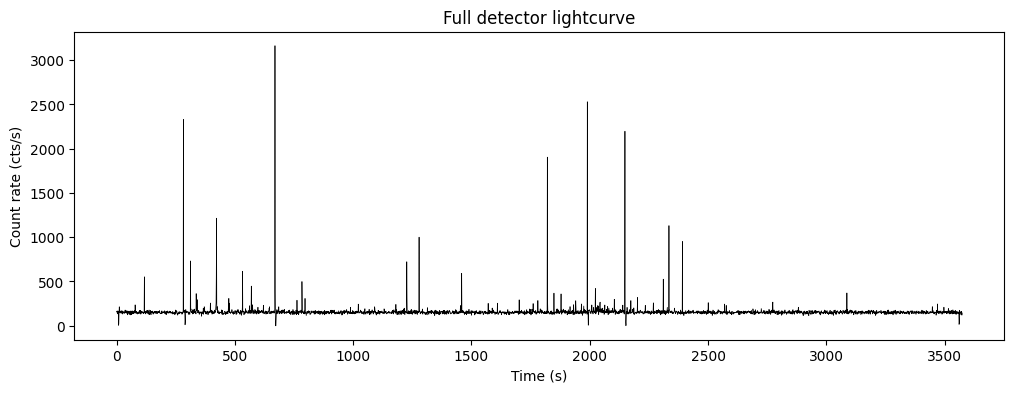

In [6]:
time, counts = lc.rebin(binsize=1.0, emin=30, emax=300)

plt.figure(figsize=(12, 4))
plt.plot(time, counts, "k-", lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Count rate (cts/s)")
plt.title("Full detector lightcurve")
plt.show()

## 4. Energy-Resolved Lightcurves
```python
# Compare soft vs hard band

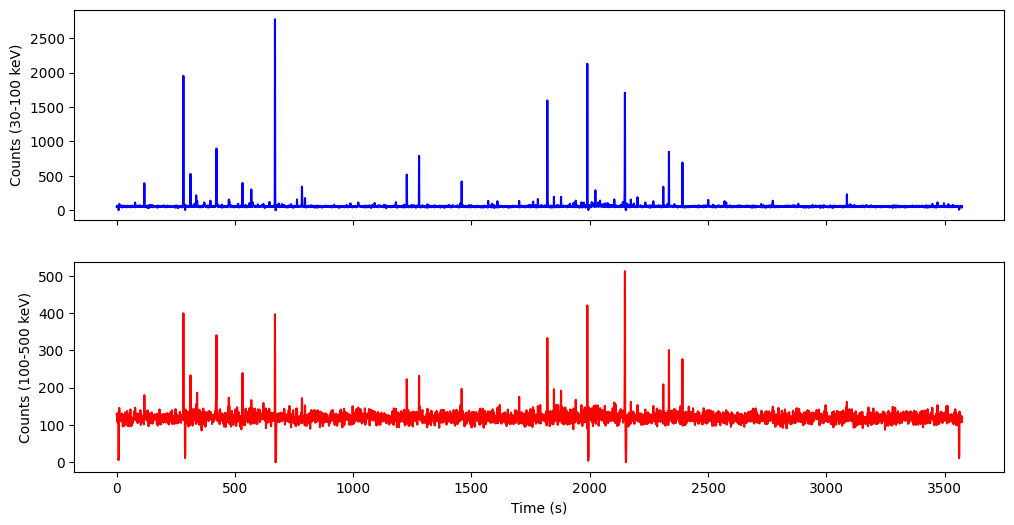

In [16]:
time_soft, counts_soft = lc.rebin(binsize=1.0, emin=30, emax=100)
time_hard, counts_hard = lc.rebin(binsize=1.0, emin=100, emax=500)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(time_soft, counts_soft, "b-")
ax1.set_ylabel("Counts (30-100 keV)")
ax2.plot(time_hard, counts_hard, "r-")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Counts (100-500 keV)")
plt.show()

## 5. Module-by-Module Analysis

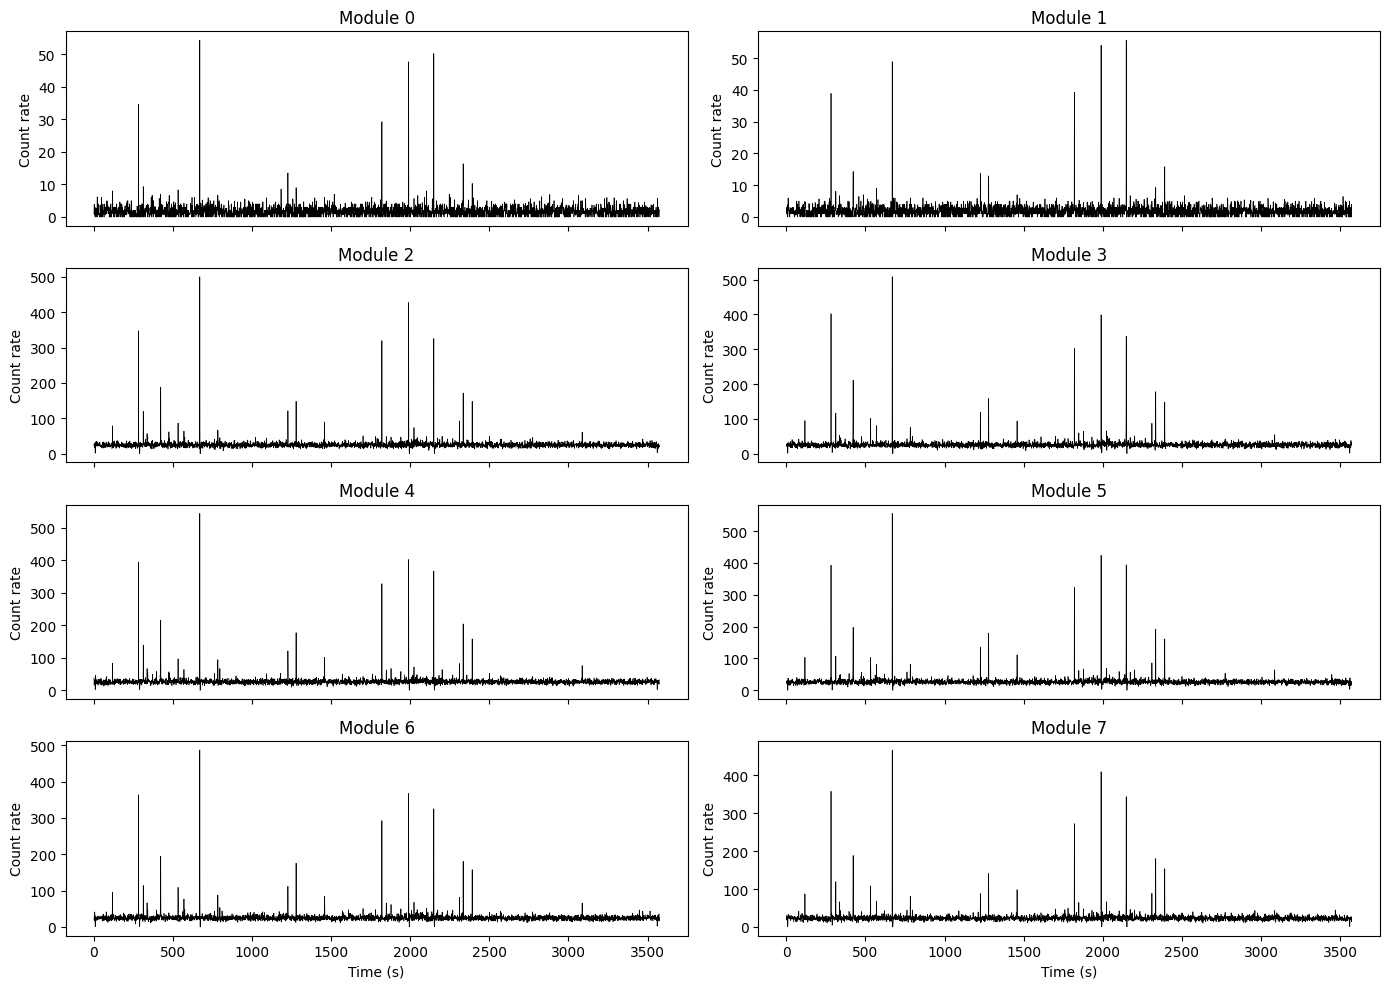

In [38]:
# Get lightcurves for all 8 modules
times, module_counts = lc.rebin_by_modules(binsize=1.0, emin=30, emax=300)

# Plot all modules
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
for i, ax in enumerate(axes.flat):
    ax.plot(times, module_counts[i], "k-", lw=0.5)
    ax.set_title(f"Module {i}")
    ax.set_ylabel("Count rate")
    if i >= 6:  # Only bottom row
        ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

## 6. Time Conversions


In [3]:
from isgri.utils.time_conversion import ijd2utc, utc2ijd

# IJD to UTC
print(f"Start time UTC: {ijd2utc(lc.t0)}. End time UTC: {ijd2utc(lc.time[-1])}")

# Local time (seconds from start)
print(f"Event at t=100s → IJD {lc.loc2ijd(100):.4f}")

# Work in IJD time instead
time_ijd, counts = lc.rebin(binsize=1.0, emin=30, emax=300, local_time=False)
print(f"IJD time range: {time_ijd[0]:.4f} - {time_ijd[-1]:.4f}")

Start time UTC: 2022-10-12 15:09:21.727. End time UTC: 2022-10-12 16:08:55.718
Event at t=100s → IJD 8320.6335
IJD time range: 8320.6323 - 8320.6737


## 7. Quality Metrics

In [3]:
from isgri.utils import QualityMetrics

# Compute chi-squared for variability assessment
qm = QualityMetrics(lc, binsize=1.0, emin=30, emax=300)

# Raw chi-squared
chi_raw = qm.raw_chi_squared()
print(f"Raw chisq reduced: {chi_raw:.2f}")

# Sigma-clipped (removes outliers)
chi_clipped = qm.sigma_clip_chi_squared(sigma=1)
print(f"Clipped chisq reduced: {chi_clipped:.2f}")

# GTI-filtered
chi_gti = qm.gti_chi_squared()
print(f"GTI chisq reduced: {chi_gti:.2f}")

# Per-module analysis
chi_modules = qm.raw_chi_squared(return_all=True)
print(f"Module variability: {chi_modules}")

Raw chisq reduced: 10.04
Clipped chisq reduced: 1.00
GTI chisq reduced: 10.03
Module variability: (array([ 6359.549,  6926.603, 35261.777, 36130.625, 38277.758, 39590.93 ,
       33664.773, 35566.195], dtype=float32), array([2942, 3025, 3567, 3568, 3568, 3568, 3568, 3567]), array([ 6185.0806,  6649.9795, 91052.58  , 93023.62  , 97074.28  ,
       96712.97  , 91139.47  , 85202.89  ], dtype=float32))


## 8. Custom Analysis


In [5]:
# Count events in specific time window
counts_burst = lc.cts(t1=50, t2=60, emin=30, emax=300, local_time=True)
print(f"Counts during burst: {counts_burst:.0f}")


Counts during burst: 1451


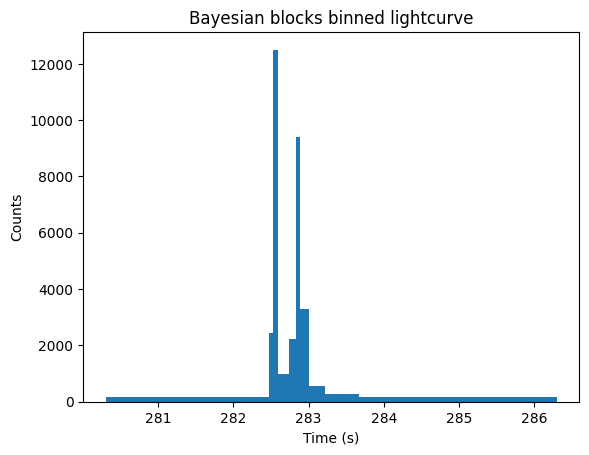

In [28]:
# Custom binning (bayesian blocks)
from astropy.stats import bayesian_blocks

time_mask = (lc.local_time >= 280) & (lc.local_time <= 286)
edges = bayesian_blocks(lc.local_time[time_mask])
time_bb, counts_bb = lc.rebin(binsize=edges, emin=30, emax=300, local_time=True, custom_mask=time_mask)
rate_bb = counts_bb / np.diff(edges)
fig, ax = plt.subplots()
ax.bar(time_bb, rate_bb, width=np.diff(edges), align="edge")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Counts")
ax.set_title("Bayesian blocks binned lightcurve")
plt.show()

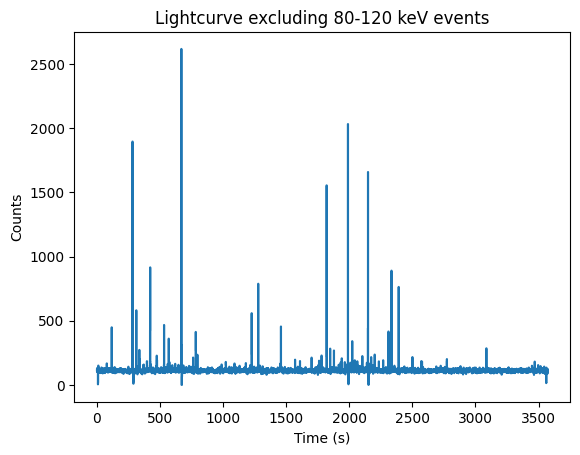

In [34]:
# Custom event selection
high_energy_mask = (lc.energies < 80) | (lc.energies > 120)  # Exclude events between 80-120 keV
time, counts = lc.rebin(binsize=1.0, emin=30, emax=300, custom_mask=high_energy_mask)
fig, ax = plt.subplots()
ax.step(time, counts, where="mid")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Counts")
ax.set_title("Lightcurve excluding 80-120 keV events")
plt.show()